# Leveraging BLIP for poor segmentation: demo

https://arxiv.org/html/2312.04539v1/

Some notebook links

 - [Setup](#Setup)

## Setup

In [2]:
# # install Rust for HF tokenizers
# !curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh

In [3]:
## Not really needed
# # install requirements
# import sys
# !RUSTUP_TOOLCHAIN=1.72.0 pip3 install -q transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install -q transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
#     !git clone https://github.com/salesforce/BLIP
#     %cd BLIP

In [4]:
# install requirements
import sys
!pip3 install -q transformers timm fairscale

# # !RUSTUP_TOOLCHAIN=1.72.0 pip3 install -q transformers timm fairscale
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install -q transformers timm fairscale
#     !git clone https://github.com/salesforce/BLIP
#     %cd BLIP

In [5]:
%pip install -q torch-kmeans torcheval spacy

Note: you may need to restart the kernel to use updated packages.


In [6]:
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
!pip freeze

absl-py==2.1.0
aiohttp==3.9.5
aiosignal==1.3.1
annotated-types==0.7.0
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
awscrt==0.20.9
Babel==2.15.0
backoff==2.2.1
beautifulsoup4==4.12.3
bleach==6.1.0
blis==0.7.11
boto3==1.34.117
botocore==1.34.117
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
cloudpathlib==0.18.1
comm==0.2.2
confection==0.1.5
contourpy==1.2.1
cycler==0.12.1
cymem==2.0.8
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
dnspython==2.6.1
email_validator==2.1.1
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl#sha256=86cc141f63942d4b2c5fcee06630fd6f904788d2f0ab005cce45aadb8fb73889
exceptiongroup==1.2.1
executing==2.0.1
fairscale==0.4.13
fastapi==0.111.0
fastapi-cli==0.0.4
fastjsonschema==2.19.1
filelock==3.14.0
fire==0.6.0
fonttools==4

In [1]:
import math
import matplotlib
import matplotlib.patches
import matplotlib.pyplot as plt
import requests
import skimage.color.colorlabel
import torch
import torcheval
import torcheval.metrics

from dataclasses import dataclass
from PIL import Image
from skimage import color
from skimage import io
from textwrap import fill
from torch_kmeans import KMeans
from torchvision import transforms
from transformers import BlipProcessor, BlipForConditionalGeneration
from typing import Dict, List, Tuple

Sample image

In [2]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
# http://images.cocodataset.org/val2017/000000039769.jpg
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

## Wprawka

### No model działa :)

Czy chcemy embeddować patche niezależnie, czy razem (chyba tak, bo mamy Multi-head attention).
Oczywiście, że razem

Text generation

In [3]:
import requests
from transformers import BlipProcessor, BlipForConditionalGeneration

processor_s = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_s = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [4]:
# conditional image captioning
text = "a photography of"
inputs = processor_s(image, text, return_tensors="pt")

out = model_s.generate(**inputs)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)
# >>> a photography of a woman and her dog

# unconditional image captioning
inputs = processor_s(image, return_tensors="pt")

out = model_s.generate(**inputs)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)
# >>> a woman sitting on the beach with her dog

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a woman and her dog on the beach
a woman sitting on the beach with her dog


In [5]:
vision_outputs = model_s.vision_model.forward(
    pixel_values=inputs['pixel_values'],
    # pixel_mask=inputs['pixel_mask'],
    # return_dict=True
)
image_embeds = vision_outputs.last_hidden_state
image_embeds

tensor([[[-0.1773, -0.2170, -0.2945,  ...,  0.5116,  0.6934, -0.0700],
         [-1.0814,  0.2754, -0.2499,  ..., -1.4706,  0.0035, -0.0398],
         [-0.5621, -0.1927, -0.1502,  ..., -0.9316, -0.7027, -0.3139],
         ...,
         [ 0.3519, -0.0165, -0.0759,  ..., -0.1243, -0.0274, -0.7747],
         [-0.8698,  0.5471, -0.1587,  ..., -0.0307, -0.6847, -0.0901],
         [-0.5876,  0.5352, -0.5389,  ...,  0.0215, -0.0669, -0.3375]]],
       grad_fn=<NativeLayerNormBackward0>)

In [6]:
# no ciekawe, daliśmy wszystkie embeddingi i działa
out = model_s.text_decoder.generate(
    encoder_hidden_states=image_embeds,
    # encoder_outputs=image_embeds,
    # attention_mask=inputs['attention_mask'],
    # max_length=128,
    # num_beams=4,
    # early_stopping=True,
    # no_repeat_ngram_size=3,
    # num_return_sequences=1,
    # decoder_start_token_id=processor_s.tokenizer.pad_token_id
)
print(out)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)

tensor([[30522,  1037,  2450,  3564,  2006,  1996,  3509,  2007,  2014,  3899,
           102,   102,   102,   102,   102,   102,   102,   102,   102,   102]])
a woman sitting on the beach with her dog


In [7]:
KMeans(n_clusters=5)(torch.zeros(7)[None, :, None]).labels.unique().shape.numel()
# KMeans(n_clusters=5)(torch.zeros(7)[None, :, None]).centers

Full batch converged at iteration 1/100 with center shifts = tensor([0.]).


1

In [8]:
image_embeds.shape

torch.Size([1, 577, 768])

In [9]:
# bez tokenu CLS też daje radę
out = model_s.text_decoder.generate(
    encoder_hidden_states=image_embeds[:, 1:, :], # [bs, ntoken, hidden_state_size]
    # encoder_outputs=image_embeds,
    # attention_mask=inputs['attention_mask'],
    # max_length=128,
    # num_beams=4,
    # early_stopping=True,
    # no_repeat_ngram_size=3,
    # num_return_sequences=1,
    # decoder_start_token_id=processor_s.tokenizer.pad_token_id
)
print(out)
text_output = processor_s.decode(out[0], skip_special_tokens=True)
print(text_output)

tensor([[30522,  1037,  2450,  3564,  2006,  1996,  3509,  2007,  2014,  3899,
           102,   102,   102,   102,   102,   102,   102,   102,   102,   102]])
a woman sitting on the beach with her dog


Tokens

In [10]:
out

tensor([[30522,  1037,  2450,  3564,  2006,  1996,  3509,  2007,  2014,  3899,
           102,   102,   102,   102,   102,   102,   102,   102,   102,   102]])

## Clustering

In [11]:
# Let's assume that the preprocessing is essentially the same for the base and large models
# and we can use the same processor for both, but we will create two for different image sizes
def get_models():
    processor_s = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model_s = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    processor_l = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large", size={"height": 512, "width": 512}) # the altered size would also work with the small model
    model_l = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

    return processor_s, model_s, processor_l, model_l

In [12]:
processor_s, model_s, processor_l, model_l = get_models()

In [13]:
processor_s

BlipProcessor:
- image_processor: BlipImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: BertTokenizerFast(name_or_path='Salesforce/blip-image-captioning-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[S

In [14]:
processor_l

BlipProcessor:
- image_processor: BlipImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "BlipProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  },
  "size_divisor": 32
}

- tokenizer: BertTokenizerFast(name_or_path='Salesforce/blip-image-captioning-large', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_token

In [15]:
@dataclass
class ClusterizationResult:
    input_image: torch.Tensor
    ncluster: int
    cluster_label_assignments: torch.Tensor # for each pixel assign a cluster number
    decoded_cluster_descriptions: List[str]

In [16]:
@torch.no_grad()
def get_kmeans_cluster_assignments(models: Dict[str, Tuple[BlipProcessor, BlipForConditionalGeneration]], image, ks=(2, 8)) -> Dict[str, ClusterizationResult]:
    result = {}
    for model_processor_pair_name, (processor, blip) in models.items():
        for k in ks:
            print(f"{model_processor_pair_name}, {k=}")
            inputs = processor(image, return_tensors="pt")
            input_image_batch = inputs['pixel_values']

            # TODO see model.get_image_features
            vision_out = blip.vision_model(input_image_batch, return_dict=True, interpolate_pos_encoding=True) # important to interpolate the positional encoding! # TODO can we always do that?

            # seems we have 576 (24*24) or 1024 (32*32) patches
            image_embeds = vision_out.last_hidden_state[:, 1:, :] # [bs, num_patches, hidden_size]/[bs, 576, 768] # discard the hidden state for the CLS token

            kmeans = KMeans(n_clusters=k) #, distance='cosine') # worth trying cosine distance
            cluster_assignments = kmeans(image_embeds)

            ncluster = cluster_assignments.labels.unique().shape.numel()
            decoded_cluster_descriptions = []
            # for every cluster, apply the text decoder conditioned on the encoded patches
            # it somehow works, even if the patches are not consecutive
            for cluster in range(ncluster):
                cluster_patch_embeddings = image_embeds[:, cluster_assignments.labels[0] == cluster, :]
                # print(f"{cluster_patch_embeddings.shape=}")
                out = blip.text_decoder.generate(
                    encoder_hidden_states=cluster_patch_embeddings, # [bs, ntoken, hidden_state_size]
                    # encoder_outputs=image_embeds,
                    # attention_mask=inputs['attention_mask'],
                    # max_length=128,
                    # num_beams=4,
                    # early_stopping=True,
                    # no_repeat_ngram_size=3,
                    # num_return_sequences=1,
                    # decoder_start_token_id=processor_s.tokenizer.pad_token_id
                )
                text_output = processor_s.decode(out[0], skip_special_tokens=True)
                decoded_cluster_descriptions.append(text_output)
                print(f"{cluster=}, {text_output=}")

            # upscale the cluster assignment for the patches and reshape it to the original image resolution
            npatch = image_embeds.shape[1] # the shape is [bs, npatch, embedding_dim]
            patch_size = 16 # let's just assume that this is what we have in the model instead of passing this as a parameter that would never be changed
            image_size_in_patches = int(math.sqrt(npatch)) # 24 for the small model (24x24 16x16 patches gives 384x384 image size)
            upscaled_cluster_assignments = cluster_assignments.labels.view(image_size_in_patches, image_size_in_patches).repeat_interleave(patch_size, 0).repeat_interleave(patch_size, 1)

            result[f"{model_processor_pair_name}, {k=}"] = ClusterizationResult(
                input_image_batch[0],
                ncluster,
                upscaled_cluster_assignments,
                decoded_cluster_descriptions
            )
    return result

In [17]:
def visualize_clusters(pixel_cluster_assignments: Dict[str, ClusterizationResult]):
    plot_ncol = 2
    plot_nrow = math.ceil(len(pixel_cluster_assignments) / plot_ncol)
    plot_size = 7
    plt.figure(figsize=(plot_size * plot_ncol, plot_size * 1.75 * plot_nrow))

    plt.title("Cluster assignments for different model sizes, image sizes and number of clusters", pad=(plot_size * 7))
    plt.axis('off')

    for i, (cluster_assignment_title, cluster_assignment) in enumerate(pixel_cluster_assignments.items()):
        # we can't do this once, as the image sizes are not uniform
        mean = torch.tensor((0.48145466, 0.4578275, 0.40821073))
        std = torch.tensor((0.26862954, 0.26130258, 0.27577711))
        denormalize = transforms.Normalize(
            mean = -mean/std,
            std = 1.0 / std
        )

        original_image = denormalize(cluster_assignment.input_image).permute(1, 2, 0).numpy()

        ax = plt.subplot2grid((plot_nrow, plot_ncol), (i// plot_ncol, i % plot_ncol))
        ax.axis('off')
        ax.set_title(cluster_assignment_title)
        ax.imshow(color.label2rgb(cluster_assignment.cluster_label_assignments.numpy(), original_image, bg_label=666)) # there's no background label (yet ;))


        legend_patches = [
            matplotlib.patches.Patch(color=c, label=fill(text, width=60))
            for c, text in zip(color.colorlabel.DEFAULT_COLORS, cluster_assignment.decoded_cluster_descriptions)
        ]
        plt.legend(handles=legend_patches, bbox_to_anchor=(0.5, -0.05), loc='upper center', borderaxespad=0., fontsize='small')

        #     loc='upper center', bbox_to_anchor=(0.5, -0.05),
        #   fancybox=True, shadow=True, ncol=5)
    

    plt.tight_layout()
    # plt.tight_layout(pad=1.0, h_pad=5.0)
    plt.show()

In [18]:
color.colorlabel.DEFAULT_COLORS

('red',
 'blue',
 'yellow',
 'magenta',
 'green',
 'indigo',
 'darkorange',
 'cyan',
 'pink',
 'yellowgreen')

small model, 384x384 image, k=2


Full batch converged at iteration 16/100 with center shifts = tensor([0.]).
cluster=0, text_output='a woman sitting on the ground with a dog'
cluster=1, text_output='beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach beach'
small model, 384x384 image, k=8
Full batch converged at iteration 28/100 with center shifts = tensor([0.]).
cluster=0, text_output='the sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset sunset'
cluster=1, text_output='a white background with a black and white image of a white background with a black and white image'
cluster=2, text_output='a woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman woman'
cluster=3, text_output='a a a a a a a a a a a a a a a a a a a'
cluster=4, text_output='the waves waves waves waves waves waves waves waves waves waves waves waves waves waves waves waves waves wave

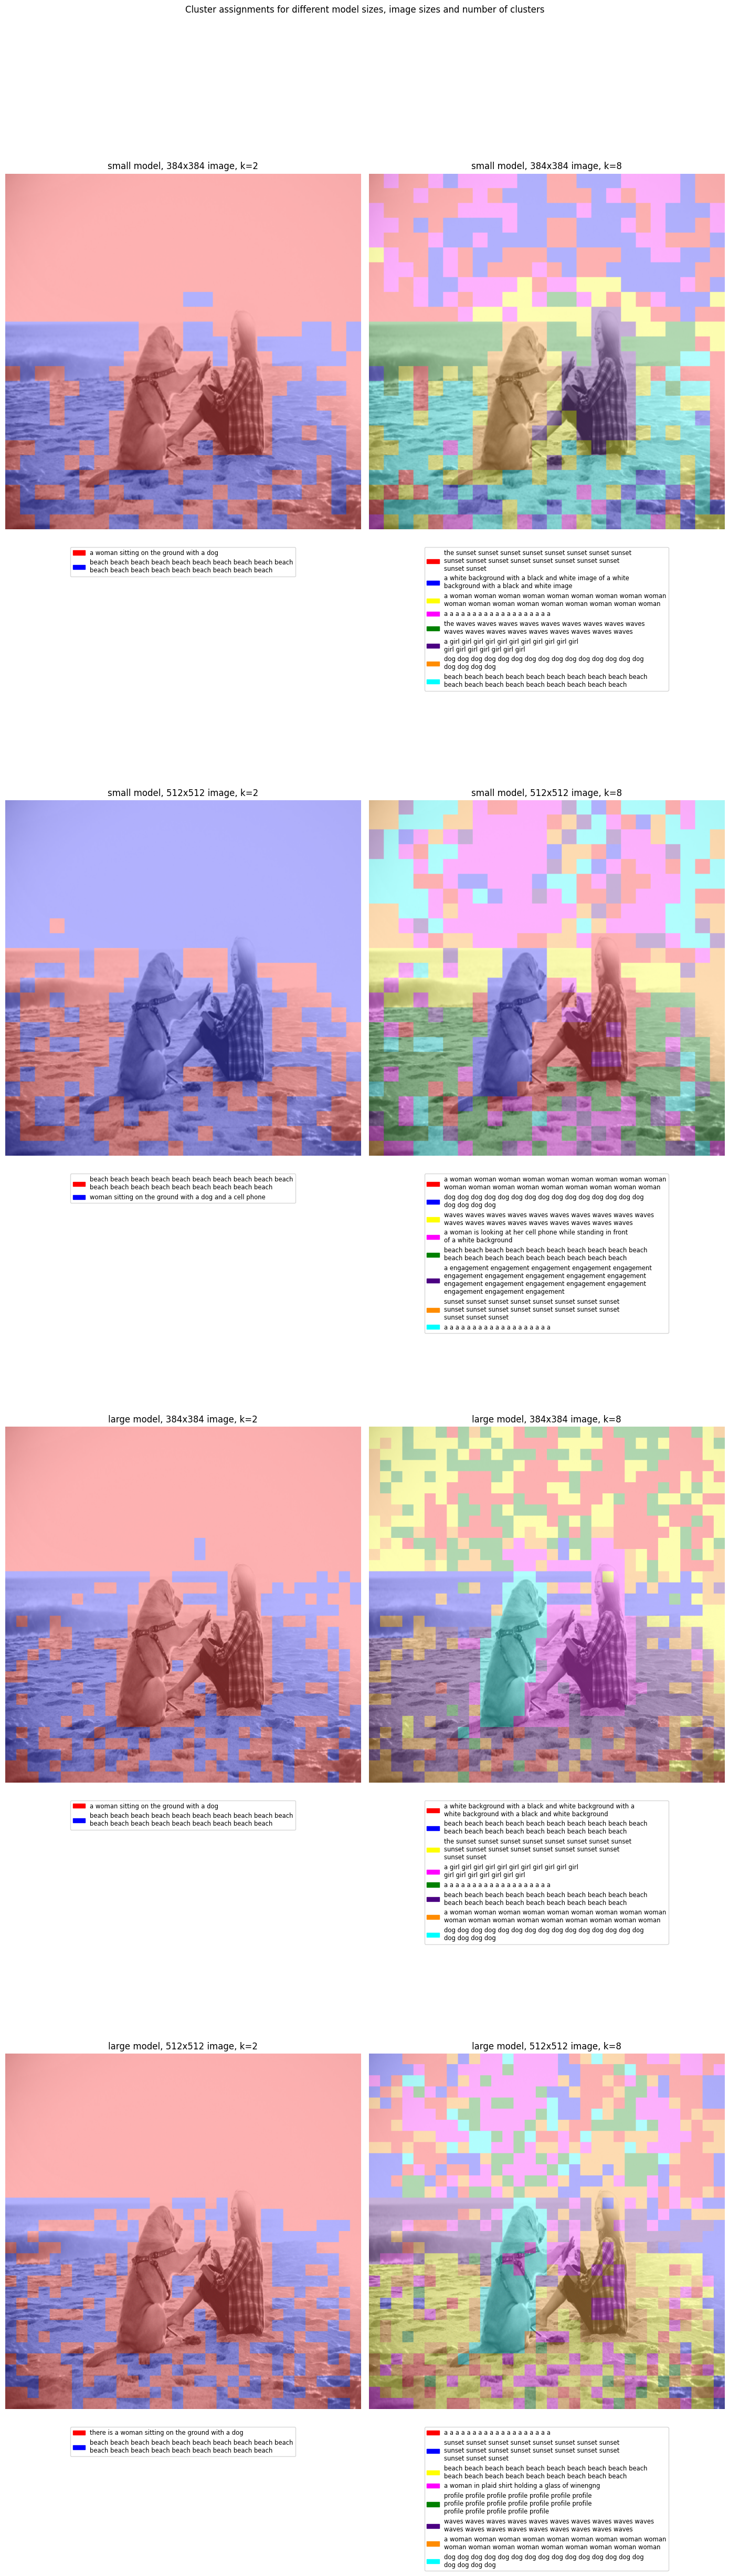

In [20]:
cluster_data = get_kmeans_cluster_assignments(
    {
        'small model, 384x384 image': (processor_s, model_s),
        'small model, 512x512 image': (processor_s, model_l),
        'large model, 384x384 image': (processor_l, model_s),
        'large model, 512x512 image': (processor_l, model_l),
    },
    image,
    ks=(2, 8)
)
visualize_clusters(cluster_data)

## Alignment

In [21]:
print(*cluster_data.keys(), sep='\n')

small model, 384x384 image, k=2
small model, 384x384 image, k=8
small model, 512x512 image, k=2
small model, 512x512 image, k=8
large model, 384x384 image, k=2
large model, 384x384 image, k=8
large model, 512x512 image, k=2
large model, 512x512 image, k=8


In [22]:
target = cluster_data['small model, 384x384 image, k=8']
input = cluster_data['small model, 512x512 image, k=2']
confusion_matrix = torcheval.metrics.functional.multiclass_confusion_matrix(
    target=target.cluster_label_assignments.flatten(), # ten co ma najwięcej
    input=input.cluster_label_assignments.flatten(),
    # torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    # torch.tensor([0, 0, 2, 3, 4, 5, 6, 7, 8, 9]),
    num_classes=cluster_data['small model, 384x384 image, k=8'].ncluster,
    # normalize=''
    # normalize='all'
)
# iou = confusion_matrix

In [23]:
confusion_matrix

tensor([[ 2816, 24064,     0,     0,     0,     0,     0,     0],
        [ 2560, 21760,     0,     0,     0,     0,     0,     0],
        [ 2304, 16896,     0,     0,     0,     0,     0,     0],
        [  768, 17152,     0,     0,     0,     0,     0,     0],
        [ 9728,  2816,     0,     0,     0,     0,     0,     0],
        [    0,  9728,     0,     0,     0,     0,     0,     0],
        [    0, 10240,     0,     0,     0,     0,     0,     0],
        [17664,  8960,     0,     0,     0,     0,     0,     0]])

In [24]:
reference_cluster_assignment = confusion_matrix.argmax(dim=0)[:input.ncluster]

In [25]:
# iou = confusion_matrix.diagonal().sum()
# iou

In [26]:
cluster_data['small model, 384x384 image, k=2'].cluster_label_assignments

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [27]:
pixel_cluster_assignments: Dict[str, ClusterizationResult]

In [28]:
def hungarian_matching_cluster_alignment(reference_cluster_set: ClusterizationResult, c_cluster_set: ClusterizationResult) -> torch.Tensor:
    """Assigns the input clusters to the reference clusters."""
    confusion_matrix = torcheval.metrics.functional.multiclass_confusion_matrix(
        target=reference_cluster_set.cluster_label_assignments.flatten(),
        input=c_cluster_set.cluster_label_assignments.flatten(),
        num_classes=reference_cluster_set.ncluster,
    )
    reference_cluster_assignment = confusion_matrix.argmax(dim=0)[:c_cluster_set.ncluster]

    return reference_cluster_assignment

In [29]:
hungarian_matching_cluster_alignment(
    cluster_data['small model, 384x384 image, k=8'],
    cluster_data['small model, 512x512 image, k=2']
)

tensor([7, 0])

In [30]:
def calculate_cluster_confidence(cluster_data: Dict[str, ClusterizationResult]) -> torch.Tensor:
    """The returned value is actually a segmentation mask"""
    reference_set_name: str = max(cluster_data.keys(), key=lambda x: cluster_data[x].ncluster)
    reference_cluster_set = cluster_data[reference_set_name]
    c_cluster_set_names = [model_name for model_name in cluster_data if model_name != reference_set_name]

    reference_cluster_masks = {c: [] for c in range(reference_cluster_set.ncluster)}

    for c_cluster_set_name in c_cluster_set_names:
        c_cluster_set = cluster_data[c_cluster_set_name]
        reference_cluster_assignment = hungarian_matching_cluster_alignment(reference_cluster_set, c_cluster_set)

        original_c_pixel_labels = c_cluster_set.cluster_label_assignments
        # c_mask_new_pixel_labels = 
        print(f"{original_c_pixel_labels.shape=}")

        c_masks_before_relabelling = original_c_pixel_labels[None, :, :] == torch.arange(c_cluster_set.ncluster)[:, None, None]
        
        print(f"{c_masks_before_relabelling.shape=}")

        # c_masks_

        # reference_cluster_masks.append(
        # )
        # print(torch.arange(c_cluster_set.ncluster)[:, None])
        # print(reference_cluster_masks[-1].shape)
        # break

        # # calculate the intersection over union
        # confusion_matrix = torcheval.metrics.functional.multiclass_confusion_matrix(
        #     target=reference_cluster_set.cluster_label_assignments.flatten(),
        #     input=c_cluster_set.cluster_label_assignments.flatten(),
        #     num_classes=reference_cluster_set.ncluster,
        # )
        # iou = confusion_matrix[reference_cluster_assignment, torch.arange(c_cluster_set.ncluster)].float().sum() / (confusion_matrix.sum(dim=0) + confusion_matrix.sum(dim=1) - confusion_matrix[reference_cluster_assignment, torch.arange(c_cluster_set.ncluster)].float()).clamp(min=1e-6)

        # calculate the confidence of the
    
    # reference_cluster_masks = torch.mean(torch.stack(reference_cluster_masks, dim=0).float(), dim=0)

    return reference_cluster_masks

In [31]:
calculate_cluster_confidence(cluster_data)

original_c_pixel_labels.shape=torch.Size([384, 384])
c_masks_before_relabelling.shape=torch.Size([2, 384, 384])
original_c_pixel_labels.shape=torch.Size([384, 384])
c_masks_before_relabelling.shape=torch.Size([2, 384, 384])
original_c_pixel_labels.shape=torch.Size([384, 384])
c_masks_before_relabelling.shape=torch.Size([8, 384, 384])


ValueError: The `input` and `target` should have the same first dimension, got shapes torch.Size([262144]) and torch.Size([147456]).




































































































































































































### Patch embeddings (large)

### Clustering

### Cluster Alignment

### Denoising

### Noun Generation by filtering BLIP Decoder output from the clusters

In [ ]:
import spacy
# from spacy.lang.en.examples import sentences

nlp = spacy.load("en_core_web_sm")
# doc = nlp(sentences[0])
# print(doc.text)
# for token in doc:
#     print(token.text, token.pos_, token.dep_)

# # now filter nouns from the document
# nouns = [token.text for token in doc if token.pos_ == "NOUN"]
# print(nouns)

doc = nlp('Ala has an awful cat that has some fur')
nouns = [token.text for token in doc if token.pos_ == "NOUN"]
print(nouns)

['cat', 'fur']


### Forwarding Generated Nouns to the Segmentor

### Evaluation?